# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3995696613900756681
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 4.939s 


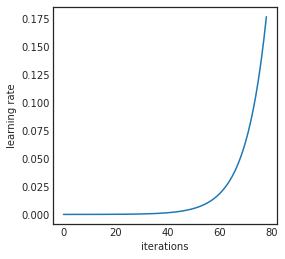

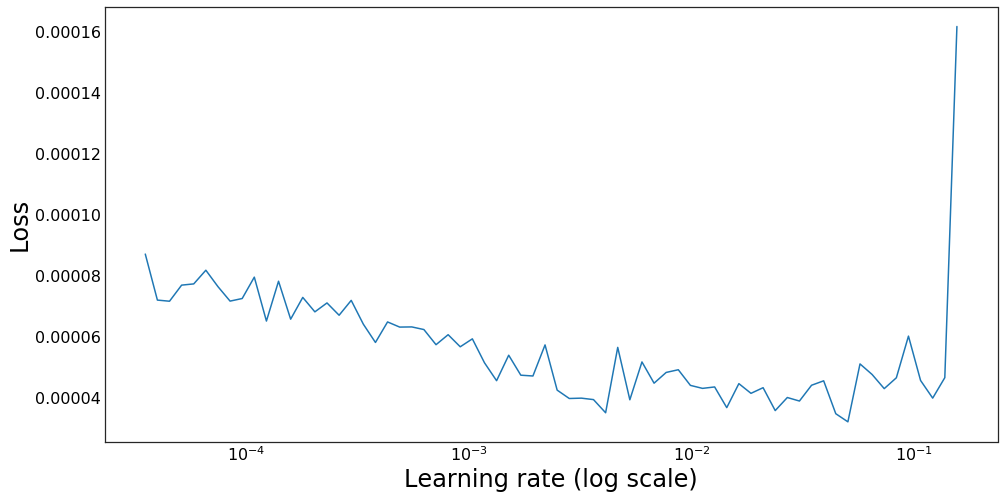

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 5e-3

In [9]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [10]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if self.sgdReplacement:
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.6990914437726756e-05
2 New best found: 3.650615441080117e-05
3 New best found: 3.5852552575434304e-05
4 New best found: 3.536147761356863e-05
5 New best found: 3.480264799940629e-05
9 New best found: 3.403364820173654e-05
11 New best found: 3.4032323367068225e-05
13 New best found: 3.338421770849074e-05
16 New best found: 3.332104271578189e-05
20 New best found: 3.310805404146815e-05
23 New best found: 3.309200091669394e-05
25 New best found: 3.309065785918963e-05
32 New best found: 3.3075794595424415e-05
36 New best found: 3.283931764983189e-05
37 New best found: 3.2816240941343956e-05
44 New best found: 3.265481176437162e-05
53 New best found: 3.259943734122814e-05
60 New best found: 3.2475023039333153e-05
69 New best found: 3.243130427055578e-05
74 New best found: 3.240079167451562e-05
86 New best found: 3.2301377204517866e-05
115 New best found: 3.21796002720452e-05
119 New best 

model is 52 epochs old
new model is 52 epochs old
177 swa loss 3.161686343206714e-05, default loss 3.3002872225622484e-05
model is 53 epochs old
new model is 53 epochs old
178 swa loss 3.161543498631501e-05, default loss 3.24817274931459e-05
model is 54 epochs old
new model is 54 epochs old
179 swa loss 3.161466262952584e-05, default loss 3.242254004430694e-05
179 New best found: 3.161466262952584e-05
model is 55 epochs old
new model is 55 epochs old
180 swa loss 3.162106001978262e-05, default loss 3.335222525540278e-05
model is 56 epochs old
new model is 56 epochs old
181 swa loss 3.16209964610077e-05, default loss 3.236286533050411e-05
model is 57 epochs old
new model is 57 epochs old
182 swa loss 3.1622803600174105e-05, default loss 3.2425771243844236e-05
model is 58 epochs old
new model is 58 epochs old
183 swa loss 3.162397348174024e-05, default loss 3.2469472909007836e-05
model is 59 epochs old
new model is 59 epochs old
184 swa loss 3.1625662411633686e-05, default loss 3.2563716

model is 5 epochs old
new model is 5 epochs old
130 swa loss 3.186036600805478e-05, default loss 3.266881690178483e-05
130 New best found: 3.186036600805478e-05
model is 6 epochs old
new model is 6 epochs old
131 swa loss 3.1831801752734455e-05, default loss 3.2523217950060425e-05
131 New best found: 3.1831801752734455e-05
model is 7 epochs old
new model is 7 epochs old
132 swa loss 3.183742053051575e-05, default loss 3.257118348233374e-05
model is 8 epochs old
new model is 8 epochs old
133 swa loss 3.1840318000473705e-05, default loss 3.2777047495944957e-05
model is 9 epochs old
new model is 9 epochs old
134 swa loss 3.183026901866009e-05, default loss 3.2239033146660724e-05
134 New best found: 3.183026901866009e-05
model is 10 epochs old
new model is 10 epochs old
135 swa loss 3.1819600297034515e-05, default loss 3.227953845344615e-05
135 New best found: 3.1819600297034515e-05
model is 11 epochs old
new model is 11 epochs old
136 swa loss 3.18149824052356e-05, default loss 3.26626644

model is 65 epochs old
new model is 65 epochs old
190 swa loss 3.1753736937981164e-05, default loss 3.291202821120751e-05
model is 66 epochs old
new model is 66 epochs old
191 swa loss 3.175191970272329e-05, default loss 3.2646274147644865e-05
model is 67 epochs old
new model is 67 epochs old
192 swa loss 3.1748667869147154e-05, default loss 3.219927768767668e-05
model is 68 epochs old
new model is 68 epochs old
193 swa loss 3.175047228953782e-05, default loss 3.255620123591984e-05
model is 69 epochs old
new model is 69 epochs old
194 swa loss 3.175503023699157e-05, default loss 3.363835325342091e-05
model is 70 epochs old
new model is 70 epochs old
195 swa loss 3.175710602066219e-05, default loss 3.2817001631570626e-05
model is 71 epochs old
new model is 71 epochs old
196 swa loss 3.1757142129798166e-05, default loss 3.2684628569351775e-05
model is 72 epochs old
new model is 72 epochs old
197 swa loss 3.1754974597069614e-05, default loss 3.233971166387103e-05
model is 73 epochs old
ne

model is 26 epochs old
new model is 26 epochs old
151 swa loss 3.098923053505034e-05, default loss 3.2198786678362554e-05
151 New best found: 3.098923053505034e-05
model is 27 epochs old
new model is 27 epochs old
152 swa loss 3.098833896593818e-05, default loss 3.168555654001445e-05
152 New best found: 3.098833896593818e-05
model is 28 epochs old
new model is 28 epochs old
153 swa loss 3.0985094023936676e-05, default loss 3.1629442214193904e-05
153 New best found: 3.0985094023936676e-05
model is 29 epochs old
new model is 29 epochs old
154 swa loss 3.09791293789302e-05, default loss 3.188075274422172e-05
154 New best found: 3.09791293789302e-05
model is 30 epochs old
new model is 30 epochs old
155 swa loss 3.099027878176941e-05, default loss 3.2695889246140534e-05
model is 31 epochs old
new model is 31 epochs old
156 swa loss 3.0987644317426344e-05, default loss 3.1701506104337015e-05
model is 32 epochs old
new model is 32 epochs old
157 swa loss 3.099029082716441e-05, default loss 3.

model is 5 epochs old
new model is 5 epochs old
130 swa loss 3.254651153256418e-05, default loss 3.350678810238605e-05
130 New best found: 3.254651153256418e-05
model is 6 epochs old
new model is 6 epochs old
131 swa loss 3.257832014351152e-05, default loss 3.3418372561573054e-05
model is 7 epochs old
new model is 7 epochs old
132 swa loss 3.2549008999194486e-05, default loss 3.312125946540618e-05
model is 8 epochs old
new model is 8 epochs old
133 swa loss 3.2561116619035604e-05, default loss 3.351991423842265e-05
model is 9 epochs old
new model is 9 epochs old
134 swa loss 3.2518207565590274e-05, default loss 3.32712340328726e-05
134 New best found: 3.2518207565590274e-05
model is 10 epochs old
new model is 10 epochs old
135 swa loss 3.2504645893641284e-05, default loss 3.295673144748434e-05
135 New best found: 3.2504645893641284e-05
model is 11 epochs old
new model is 11 epochs old
136 swa loss 3.249076885986142e-05, default loss 3.301274324476253e-05
136 New best found: 3.249076885

model is 66 epochs old
new model is 66 epochs old
191 swa loss 3.2415682007558644e-05, default loss 3.369985527533572e-05
model is 67 epochs old
new model is 67 epochs old
192 swa loss 3.2410287816310305e-05, default loss 3.269204518583137e-05
192 New best found: 3.2410287816310305e-05
model is 68 epochs old
new model is 68 epochs old
193 swa loss 3.240801787615055e-05, default loss 3.31644184916513e-05
193 New best found: 3.240801787615055e-05
model is 69 epochs old
new model is 69 epochs old
194 swa loss 3.240954894281458e-05, default loss 3.316531429300085e-05
model is 70 epochs old
new model is 70 epochs old
195 swa loss 3.2410428709408735e-05, default loss 3.357727616239572e-05
model is 71 epochs old
new model is 71 epochs old
196 swa loss 3.241174340073485e-05, default loss 3.3204744471004235e-05
model is 72 epochs old
new model is 72 epochs old
197 swa loss 3.241044092719676e-05, default loss 3.309321920605725e-05
model is 73 epochs old
new model is 73 epochs old
198 swa loss 3.

24 New best found: 3.338031663588481e-05
25 New best found: 3.314613438560627e-05
46 New best found: 3.278703911637422e-05
53 New best found: 3.277287107193843e-05
62 New best found: 3.276540712686255e-05
104 New best found: 3.2756284685456195e-05
118 New best found: 3.269902697356883e-05
121 New best found: 3.265463329589693e-05
122 New best found: 3.258077012287686e-05
SWA beginning
model is 0 epochs old
125 swa loss 3.278101087344112e-05, default loss 3.278101087344112e-05
model is 1 epochs old
new model is 1 epochs old
126 swa loss 3.23958422683063e-05, default loss 3.279387590155238e-05
126 New best found: 3.23958422683063e-05
model is 2 epochs old
new model is 2 epochs old
127 swa loss 3.232306083227741e-05, default loss 3.272680731897708e-05
127 New best found: 3.232306083227741e-05
model is 3 epochs old
new model is 3 epochs old
128 swa loss 3.228108592011267e-05, default loss 3.2764579099602994e-05
128 New best found: 3.228108592011267e-05
model is 4 epochs old
new model is 4 

185 swa loss 3.217040535673732e-05, default loss 3.311887682066299e-05
model is 61 epochs old
new model is 61 epochs old
186 swa loss 3.217080052709207e-05, default loss 3.2962217039312236e-05
model is 62 epochs old
new model is 62 epochs old
187 swa loss 3.2169548085948917e-05, default loss 3.2733068775269205e-05
model is 63 epochs old
new model is 63 epochs old
188 swa loss 3.217208260757616e-05, default loss 3.3369215043057924e-05
model is 64 epochs old
new model is 64 epochs old
189 swa loss 3.217077875015093e-05, default loss 3.2769699295749885e-05
model is 65 epochs old
new model is 65 epochs old
190 swa loss 3.2169129865360446e-05, default loss 3.270798526791623e-05
model is 66 epochs old
new model is 66 epochs old
191 swa loss 3.2168299847398885e-05, default loss 3.312349233456189e-05
model is 67 epochs old
new model is 67 epochs old
192 swa loss 3.2167379489692395e-05, default loss 3.2838205207372084e-05
192 New best found: 3.2167379489692395e-05
model is 68 epochs old
new mod

27 New best found: 3.3085131786356214e-05
29 New best found: 3.302537424169714e-05
46 New best found: 3.2998268296069e-05
60 New best found: 3.293459126871312e-05
62 New best found: 3.286862455715891e-05
65 New best found: 3.274251342227217e-05
78 New best found: 3.2595910504460336e-05
89 New best found: 3.2544027964468115e-05
113 New best found: 3.251726729067741e-05
SWA beginning
model is 0 epochs old
125 swa loss 3.286707360239234e-05, default loss 3.286707360239234e-05
model is 1 epochs old
new model is 1 epochs old
126 swa loss 3.2423310446029063e-05, default loss 3.264093228499405e-05
126 New best found: 3.2423310446029063e-05
model is 2 epochs old
new model is 2 epochs old
127 swa loss 3.22968539854628e-05, default loss 3.284637687975192e-05
127 New best found: 3.22968539854628e-05
model is 3 epochs old
new model is 3 epochs old
128 swa loss 3.222475500660949e-05, default loss 3.357806351268664e-05
128 New best found: 3.222475500660949e-05
model is 4 epochs old
new model is 4 ep

model is 56 epochs old
new model is 56 epochs old
181 swa loss 3.200855097238673e-05, default loss 3.288518159097293e-05
model is 57 epochs old
new model is 57 epochs old
182 swa loss 3.200950286263833e-05, default loss 3.279788927611662e-05
model is 58 epochs old
new model is 58 epochs old
183 swa loss 3.200728302326752e-05, default loss 3.285094457241939e-05
183 New best found: 3.200728302326752e-05
model is 59 epochs old
new model is 59 epochs old
184 swa loss 3.200668512727134e-05, default loss 3.2696888511418364e-05
184 New best found: 3.200668512727134e-05
model is 60 epochs old
new model is 60 epochs old
185 swa loss 3.200679887959268e-05, default loss 3.272548594031832e-05
model is 61 epochs old
new model is 61 epochs old
186 swa loss 3.200736481812783e-05, default loss 3.2765931425092276e-05
model is 62 epochs old
new model is 62 epochs old
187 swa loss 3.200773482531076e-05, default loss 3.259060661221156e-05
model is 63 epochs old
new model is 63 epochs old
188 swa loss 3.20

11 New best found: 3.394704780221218e-05
18 New best found: 3.3776563455467115e-05
19 New best found: 3.3684771160187666e-05
20 New best found: 3.354948767373571e-05
21 New best found: 3.351271708015702e-05
23 New best found: 3.33552728043287e-05
28 New best found: 3.3226717899378856e-05
29 New best found: 3.304448198614409e-05
42 New best found: 3.287241624711896e-05
49 New best found: 3.278884614701383e-05
50 New best found: 3.274289627879625e-05
64 New best found: 3.2736890451633374e-05
65 New best found: 3.2727503728528975e-05
71 New best found: 3.256784808181692e-05
79 New best found: 3.2458091876469553e-05
115 New best found: 3.239224182034377e-05
SWA beginning
model is 0 epochs old
125 swa loss 3.249715353013016e-05, default loss 3.249715353013016e-05
model is 1 epochs old
new model is 1 epochs old
126 swa loss 3.2321397417399565e-05, default loss 3.262326233816566e-05
126 New best found: 3.2321397417399565e-05
model is 2 epochs old
new model is 2 epochs old
127 swa loss 3.22416

178 swa loss 3.1897759850835427e-05, default loss 3.2593220929265955e-05
model is 54 epochs old
new model is 54 epochs old
179 swa loss 3.189862796716625e-05, default loss 3.247867503378075e-05
model is 55 epochs old
new model is 55 epochs old
180 swa loss 3.189998402376659e-05, default loss 3.278198543048347e-05
model is 56 epochs old
new model is 56 epochs old
181 swa loss 3.190321967849741e-05, default loss 3.258517969225068e-05
model is 57 epochs old
new model is 57 epochs old
182 swa loss 3.190228159946855e-05, default loss 3.277947407768806e-05
model is 58 epochs old
new model is 58 epochs old
183 swa loss 3.1901061444659716e-05, default loss 3.267703558376525e-05
model is 59 epochs old
new model is 59 epochs old
184 swa loss 3.190310145437252e-05, default loss 3.268828922373359e-05
model is 60 epochs old
new model is 60 epochs old
185 swa loss 3.190262008283753e-05, default loss 3.2801232843485195e-05
model is 61 epochs old
new model is 61 epochs old
186 swa loss 3.1904340615437

model is 22 epochs old
new model is 22 epochs old
147 swa loss 3.179688341483787e-05, default loss 3.250494706850359e-05
model is 23 epochs old
new model is 23 epochs old
148 swa loss 3.17990137327502e-05, default loss 3.300919524272071e-05
model is 24 epochs old
new model is 24 epochs old
149 swa loss 3.1800543516481686e-05, default loss 3.2867607985788595e-05
model is 25 epochs old
new model is 25 epochs old
150 swa loss 3.179403561970766e-05, default loss 3.2721588297172825e-05
model is 26 epochs old
new model is 26 epochs old
151 swa loss 3.1794601117309365e-05, default loss 3.270254644394631e-05
model is 27 epochs old
new model is 27 epochs old
152 swa loss 3.1792096761276315e-05, default loss 3.237870010931431e-05
model is 28 epochs old
new model is 28 epochs old
153 swa loss 3.1791436462119865e-05, default loss 3.250440897625701e-05
model is 29 epochs old
new model is 29 epochs old
154 swa loss 3.178509655268725e-05, default loss 3.2354123746757344e-05
model is 30 epochs old
new

206 swa loss 3.174624315349708e-05, default loss 3.2425412949058814e-05
model is 82 epochs old
new model is 82 epochs old
207 swa loss 3.174659520066441e-05, default loss 3.281598327926951e-05
model is 83 epochs old
new model is 83 epochs old
208 swa loss 3.174645288345737e-05, default loss 3.256611006912374e-05
model is 84 epochs old
new model is 84 epochs old
209 swa loss 3.17467942561702e-05, default loss 3.247892809754835e-05
model is 85 epochs old
new model is 85 epochs old
210 swa loss 3.174686227476816e-05, default loss 3.243736946291842e-05
model is 86 epochs old
new model is 86 epochs old
211 swa loss 3.1747138139941556e-05, default loss 3.314721126563267e-05
model is 87 epochs old
new model is 87 epochs old
212 swa loss 3.174675080698109e-05, default loss 3.255157045506247e-05
model is 88 epochs old
new model is 88 epochs old
213 swa loss 3.174647299775651e-05, default loss 3.238461943281561e-05
model is 89 epochs old
new model is 89 epochs old
214 swa loss 3.174717702041939e

136 swa loss 3.1710219621490664e-05, default loss 3.267604047416403e-05
136 New best found: 3.1710219621490664e-05
model is 12 epochs old
new model is 12 epochs old
137 swa loss 3.169486381872546e-05, default loss 3.210799910922857e-05
137 New best found: 3.169486381872546e-05
model is 13 epochs old
new model is 13 epochs old
138 swa loss 3.168702121912611e-05, default loss 3.2333429136238064e-05
138 New best found: 3.168702121912611e-05
model is 14 epochs old
new model is 14 epochs old
139 swa loss 3.1684730423127035e-05, default loss 3.252720933055016e-05
139 New best found: 3.1684730423127035e-05
model is 15 epochs old
new model is 15 epochs old
140 swa loss 3.168253854944544e-05, default loss 3.2335359924137486e-05
140 New best found: 3.168253854944544e-05
model is 16 epochs old
new model is 16 epochs old
141 swa loss 3.16787329366533e-05, default loss 3.246087299636689e-05
141 New best found: 3.16787329366533e-05
model is 17 epochs old
new model is 17 epochs old
142 swa loss 3.166

199 swa loss 3.1666957984840365e-05, default loss 3.243141060661706e-05
model is 75 epochs old
new model is 75 epochs old
200 swa loss 3.166288455521396e-05, default loss 3.262997724629696e-05
model is 76 epochs old
new model is 76 epochs old
201 swa loss 3.1664859426252e-05, default loss 3.307531266131552e-05
model is 77 epochs old
new model is 77 epochs old
202 swa loss 3.166575582566714e-05, default loss 3.294518971147987e-05
model is 78 epochs old
new model is 78 epochs old
203 swa loss 3.166420587397364e-05, default loss 3.234981610444098e-05
model is 79 epochs old
new model is 79 epochs old
204 swa loss 3.166542921306329e-05, default loss 3.247922200599791e-05
model is 80 epochs old
new model is 80 epochs old
205 swa loss 3.1666164548374944e-05, default loss 3.2639862443115144e-05
model is 81 epochs old
new model is 81 epochs old
206 swa loss 3.16648285862003e-05, default loss 3.2601359414445934e-05
Early stopping after 206 epochs
Score is: {'loss': 3.16252179247767e-05, 'wAUC': 

model is 44 epochs old
new model is 44 epochs old
169 swa loss 3.2055928055235014e-05, default loss 3.300134454048268e-05
model is 45 epochs old
new model is 45 epochs old
170 swa loss 3.2054984990132875e-05, default loss 3.294950178316594e-05
model is 46 epochs old
new model is 46 epochs old
171 swa loss 3.205235293893356e-05, default loss 3.300798719272861e-05
171 New best found: 3.205235293893356e-05
model is 47 epochs old
new model is 47 epochs old
172 swa loss 3.204735768878974e-05, default loss 3.2819968197902967e-05
172 New best found: 3.204735768878974e-05
model is 48 epochs old
new model is 48 epochs old
173 swa loss 3.2049151924693506e-05, default loss 3.299068854729131e-05
model is 49 epochs old
new model is 49 epochs old
174 swa loss 3.2042905067224145e-05, default loss 3.2867805187833416e-05
174 New best found: 3.2042905067224145e-05
model is 50 epochs old
new model is 50 epochs old
175 swa loss 3.2041059188174754e-05, default loss 3.2843667826576805e-05
175 New best found

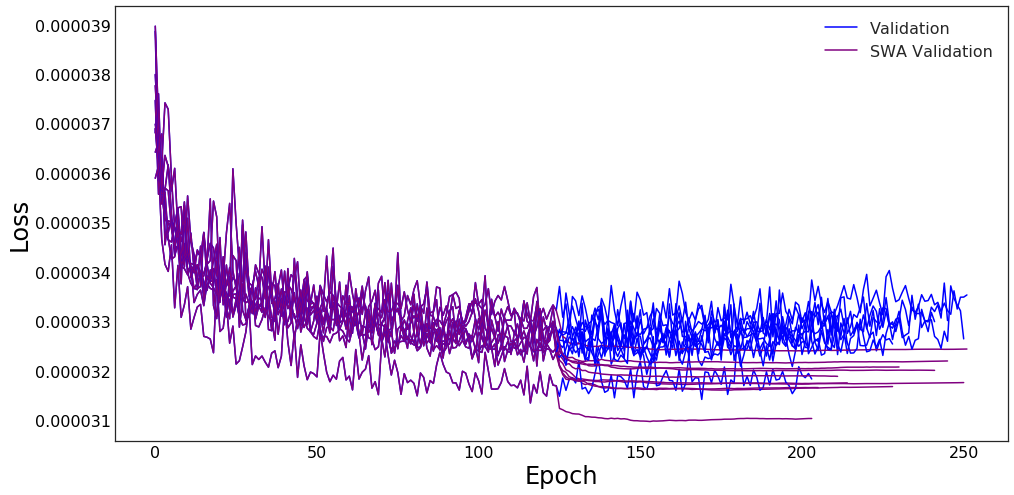

Mean loss = 3.18e-05 +- 1e-07
Mean wAUC = 0.0633 +- 0.0004
Mean AUC = 0.0992 +- 0.0007
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=125,
                                          patience=50, swaRenewal=-1, trainOnWeights=True, cosAnnealMult=0, reduxDecay=False,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"